In [124]:
#%matplotlib widget #need this for click GUIs
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt
import chipcalibration.rabi_amp_sweep as rabi
from QubicPig import jobs, chipspec
from importlib import reload
import qubic.state_disc as sd
import chipcalibration.config as cfg

In [125]:
from pygsti.processors import QubitProcessorSpec

In [126]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = cfg.load_configs(qchipname)

In [127]:
reload(rc)
runner = rc.CircuitRunnerClient(ip='192.168.1.247')

# Outline

This notebook will perform Rabi, Ramsey, and RPE calibration on a particular target qubit

TODO: calibrate a register in parallel

In [128]:
register = ['Q3']

# Rabi step

In [151]:
reload(rabi)
num_partitions = 25
target_twidth = 24e-9
irabi = rabi.RabiAmpSweeper(register, target_twidth, qchip, fpga_config, channel_config, num_partitions=num_partitions)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

In [152]:
prior_fit_params = {
    'Q0' : [-0.5, 0.5, 0.5, 0], 
    'Q1' : [-0.5, 0.5, 0.8, 0], 
    'Q2' : [-0.5, 0.5, 0.8, 0], 
    'Q3' : [-0.5, 0.5, 0.8, 0], 
    'Q4' : [-0.5, 0.5, 0.8, 0], 
    'Q5' : [-0.5, 0.5, 0.8, 0], 
}

In [153]:
qchip.gates['Q3read'].contents[0].amp = 0.008

In [154]:
irabi.run_and_fit(runner, 1000, prior_fit_params)

Taking data for qubit Q3 in batch 1 of 1


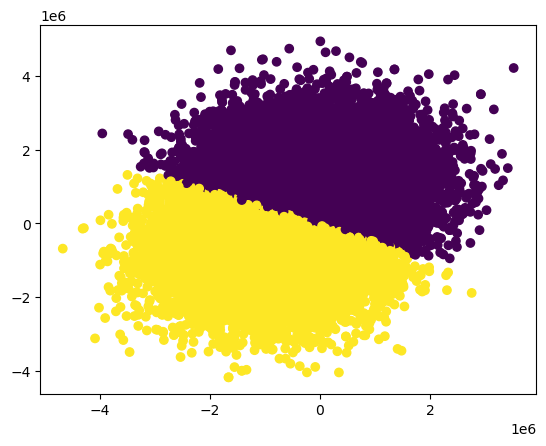

In [155]:
plt.scatter(np.real(irabi.all_raw_data['3']), np.imag(irabi.all_raw_data['3']), c=irabi.gmm_manager.gmm_dict['Q3'].predict(irabi.all_raw_data['3']))

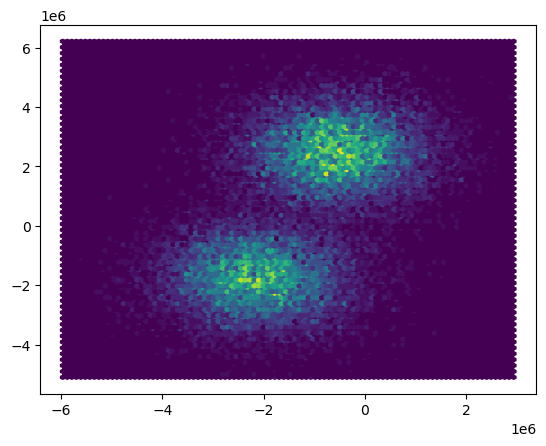

In [134]:
plt.hexbin(np.real(irabi.all_raw_data['3']), np.imag(irabi.all_raw_data['3']))

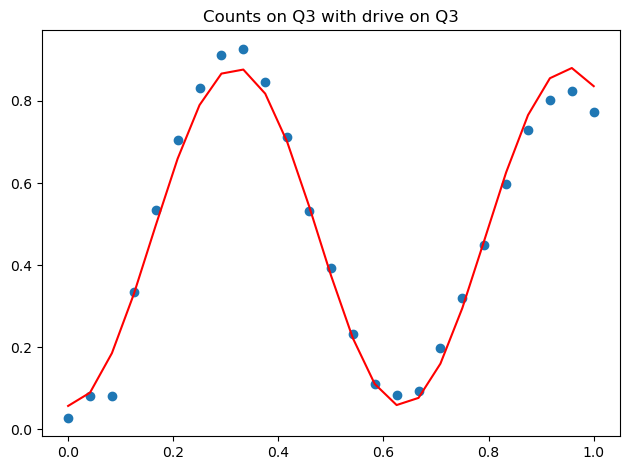

In [112]:
for qid in register:
    irabi.show_count_oscillations(qid, register, True)

In [113]:
calibrated_X90_drive_amps = {qid: irabi.fits[qid][0][2]/4 for qid in register}
print(calibrated_X90_drive_amps)

{'Q3': 0.15851024982212877}


In [114]:
print([qchip.cfg_dict['Gates'][f'{qid}X90'][0]['amp'] for qid in register])

[0.18955173016636584]


In [115]:
irabi.update_qchip(qchip)

In [116]:
print([qchip.cfg_dict['Gates'][f'{qid}X90'][0]['amp'] for qid in register])

[0.15851024982212877]


In [117]:
RABI_CALIBRATED_AMP = 0.15851024982212877

In [122]:
qchip.save('../submodules/qchip/X4Y2/qubitcfg.json')

# Ramsey step

In [118]:
import chipcalibration.ramsey as gordon

In [119]:
reload(gordon)

<module 'chipcalibration.ramsey' from '/home/jpmarceaux/chipcalibration/chipcalibration/ramsey.py'>

In [120]:
reload(gordon)
delayTime = np.linspace(0, 1.e-5, 100)
opt = gordon.RamseyOptimize([register[0]], delayTime, qchip, fpga_config, channel_config)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling


/home/jpmarceaux/chipcalibration/chipcalibration/ramsey.py:86: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-x/exp_decay)*np.cos(2*np.pi*x*drive_freq - phi) + B
/home/jpmarceaux/anaconda3/envs/qubic/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


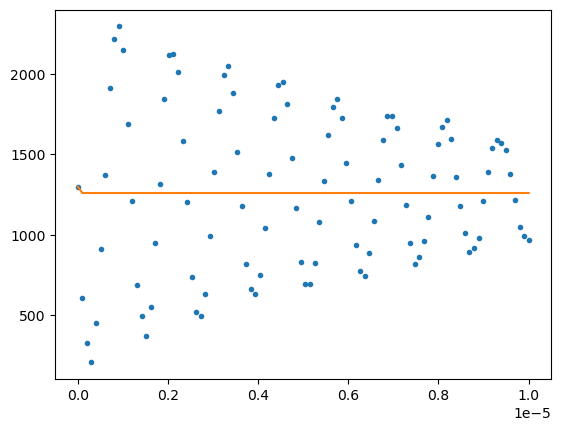

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling


/home/jpmarceaux/anaconda3/envs/qubic/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


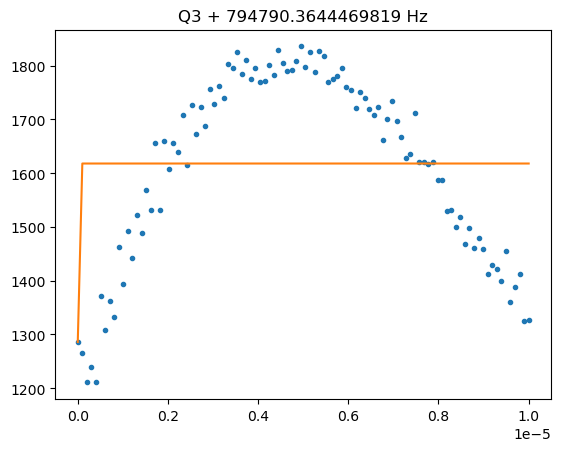

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling


KeyboardInterrupt: 

In [121]:
opt.run_optimize_step(runner, 2500, {q: [720, 500, 1/.6e-6, 0, 1.5e-5] for q in register})

In [ ]:
print(opt.initial_ramsey.fit_params[register[0]][0])
opt.update_qubit_freq(register[0], -1, qchip)

In [40]:
print(qchip.cfg_dict['Qubits'][register[0]])

{'freq': 4943285298.00028, 'readfreq': 6658150381.462994, 'freq_predicted': 5030611000.0, 'readfreq0': 6657029587.25541, 'freq_ef': 4672600000.0}


In [41]:
RAMSEY_CALIBRATED_FREQ = 4943285298.00028

# RPE step

In [42]:
center_freq = qchip.qubits[register[0]].freq
center_amp = qchip.gates[register[0] + 'X90'].contents[0].amp
print(center_amp, center_freq)

0.3928844954643107 4943285298.00028


In [44]:
from QubicPig import jobs, chipspec, rpe, qupig

In [45]:
reload(jobs)
reload(chipspec)
reload(rpe)
reload(qupig)

<module 'QubicPig.qupig' from '/home/jpmarceaux/chipcalibration/notebooks/QubicPig/qupig.py'>

In [46]:
pspec = QubitProcessorSpec(num_qubits=1, qubit_labels=register, 
                           gate_names=['Gxpi2', 'Gzpi2'], geometry='line')
cs = chipspec.ChipSpec(pspec, qchip, irabi.gmm_manager)

In [47]:
jm = jobs.JobManager(cs, fpga_config, channel_config)

In [48]:
from QubicPig import rpe

In [49]:
rpe = rpe.RpeX90(cs, register[0], 6)
num_shots = 1000

In [57]:
ds = jm.collect_pygsti_dataset(rpe.circuits(), num_shots, runner)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

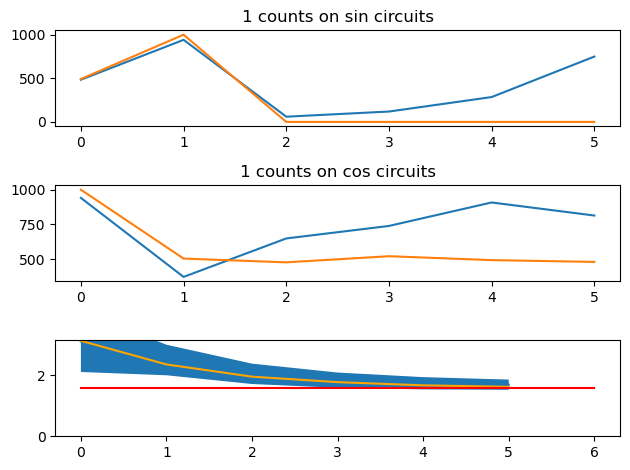

In [58]:
rpe.plot_rpe_verbose(ds, num_shots)

In [59]:
fit = rpe.process_rpe(ds)

In [60]:
fit.angle_estimates

array([3.10532738, 2.49743824, 2.04512432, 1.837177  , 1.73683444,
       1.68992279])

In [61]:
last_good_estimate_generation = fit.check_unif_local(historical=True)

In [62]:
last_good_estimate_generation

2

In [63]:
fit.angle_estimates[last_good_estimate_generation]

2.0451243246657236

In [64]:
from scipy.optimize import minimize

In [39]:
def estimate_angle_with_params(rpe_experiment, drive_amp, freq, num_shots,
                               job_manager, runner):
    print(f'Estimate with {drive_amp} amp and {freq} frequency')
    rpe_experiment.update_drive_amp(drive_amp)
    rpe_experiment.update_frequency(freq)
    ds = job_manager.collect_pygsti_dataset(rpe_experiment.circuits(), num_shots, runner)
    fit = rpe.process_rpe(ds)
    last_good_estimate_generation = fit.check_unif_local(historical=True)
    print(f'Gave an estimate {fit.angle_estimates[last_good_estimate_generation]} and a generation length {last_good_estimate_generation}')
    return fit.angle_estimates, last_good_estimate_generation
    

In [40]:
estimate_angle_with_params(rpe, center_amp, center_freq, 1000, jm, runner)

Estimate with 0.37038151052885493 amp and 4946452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done sche

100%|██████████| 11/11 [00:07<00:00,  1.52it/s]

Gave an estimate 1.9974499340259961 and a generation length 2


(array([3.1582182 , 2.38703418, 1.99744993, 1.77667974, 1.68908051,
        1.64095828]),
 2)

In [249]:
np.log10(RAMSEY_CALIBRATED_FREQ)

9.669975361891652

In [44]:
amp_bandwidth = 0.01
freq_bandwidth = 1e6

In [45]:
from scipy.optimize import minimize

RUNNER = runner
JOBMANAGER = jm

def cost_function(params, args):
    rpe_experiment, num_shots = args
    angles, last_good_generation = estimate_angle_with_params(rpe_experiment, 
                        params[0], params[1], num_shots, JOBMANAGER, RUNNER)
    return abs(angles[last_good_generation] - np.pi/2)

def optimize_rpe(rpe_experiment, center_freq, freq_bw, 
                 center_amp, amp_bw, num_counts):
    bounds = [
        (center_amp - amp_bw, center_amp + amp_bw), 
        (center_freq - freq_bw, center_freq + freq_bw)
    ]
    initial_params = [center_amp, center_freq]
    result = minimize(cost_function, initial_params, args=[rpe_experiment, num_shots], 
                      method='nelder-mead', bounds=bounds, options={'xatol': 1/10000, 'disp': True})
    return result

In [ ]:
results = optimize_rpe(rpe, RAMSEY_CALIBRATED_FREQ, freq_bandwidth, RABI_CALIBRATED_AMP, amp_bandwidth,  5000)

Estimate with 0.37038151052885493 amp and 4946452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done sche

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.987970485428236 and a generation length 2
Estimate with 0.38038151052885494 amp and 4946452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


Gave an estimate 2.03453364602779 and a generation length 2
Estimate with 0.37038151052885493 amp and 4947452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9902980726887731 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9440900313092724 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9283216254671172 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9224732567085374 and a generation length 2
Estimate with 0.3603815105288549 amp and 4945952235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9352436982660763 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947452235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.928491069101154 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947202235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.920013002271795 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946202235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9379437289668073 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947139735.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.92336235025944 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946514735.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.925579220063217 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946983485.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9384157670574846 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946827235.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9192436065764824 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947170985.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9396548967680185 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946858485.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9391164576717341 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946936610.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.921764819952594 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947092860.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9453156013553072 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946975673.2257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.94546802902621 and a generation length 2
Estimate with 0.3603815105288549 amp and 4947014735.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.938844429256614 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946881923.2257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.931672741495575 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946694423.2257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9345926136856495 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946774501.3507805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9434299113810756 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946854579.4757805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9328133840100223 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946920985.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9439603216235672 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946760829.4757805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9403436771839195 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946800868.5382805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9370790129686568 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6632805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.915918060366745 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946920985.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.930885916911075 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946853602.9132805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.92148465215908 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946853847.0539055 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9540763644592816 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946854091.1945305 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


Gave an estimate 1.9534111951693491 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946867763.0695305 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9415257070503102 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946894618.5382805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.925497523008153 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946907802.1320305 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9329662560124299 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946897792.3664055 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9359525213547575 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946887782.6007805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


Gave an estimate 1.9261647433201965 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946874354.8664055 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9368869392501264 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946894374.3976555 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9415737447112456 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946879359.749218 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9221203038639563 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946872523.811718 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9186797003918838 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946874110.7257805 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9363912217550896 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946878047.493359 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9405777583885309 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946876735.237499 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.923290093187366 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880153.206249 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.924915714512091 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946877528.6945305 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9487732213912516 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946879497.07832 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9227637937810276 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946883708.504101 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.932134402953943 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946878478.55415 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9543670473069015 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880221.8708 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9344505951438349 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946878840.95039 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9284985471903504 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946879565.74287 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9399695934277208 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880057.838818 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9334868583737062 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946879729.774853 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9240532240946322 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946881835.487743 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.938523118580103 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946879589.584728 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.93320965495414 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880338.219067 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9354677313630133 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946879893.806835 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9391164576717341 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946881391.075512 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9401935578046745 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880268.124004 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9437563098434971 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880642.441174 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9269280849745554 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880420.235058 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.923569881448799 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880724.457165 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.927720121508227 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880662.945171 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.928096742058298 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880683.449169 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9178967729893974 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880794.552227 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9453865572412468 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880835.560223 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9273949720756167 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880825.308224 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9485133697133188 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880815.056225 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9413314380267614 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880870.607754 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9447136195159302 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880891.111752 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9485240379731057 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880875.733753 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9324739908544943 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946881007.340809 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9266673674614734 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946881078.270336 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9319270769976988 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946881027.63619 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.926603390665122 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880966.958662 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9350315979306818 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880997.245272 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.941133711918706 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880987.149735 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9419779041892848 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880977.002045 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.934797297368264 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880936.51559 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9369650176015125 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880949.174126 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9482967695249234 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880961.832663 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9284838216739928 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880966.9065075 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.928253991717193 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880951.737125 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9368114903313367 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880959.308779 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9392734307447543 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880956.784894 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9404332964397313 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880954.247972 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9493493054549225 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880949.200202 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9513368621173688 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880952.986029 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9368315981089819 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880942.864415 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9473540821877167 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880953.304774 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9469632576524774 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880949.824655 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9259512749369423 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880951.724087 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9206096818857594 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880948.562713 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9353444858098376 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880949.509169 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9265105892074046 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880949.193684 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9301050731105707 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880948.243967 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9236196567482151 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880945.713564 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9398591906085854 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880948.323654 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9293212248941387 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.583593 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9252503223428783 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880947.018608 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.926135574060839 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880947.453624 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9310697742046425 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880947.493467 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9309999222925178 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.703124 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9416029332691982 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880947.265999 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9213924334787864 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.435812 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9239180756902627 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.700226 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.933253874913586 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.96464 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9246799100168432 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880947.078374 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9483454417460981 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.549546 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9369650176015125 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.681753 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9350315979306818 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.946167 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9253330763948044 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.880063 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.932134402953943 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.81396 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9369650176015125 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.672517 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9374211013310592 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.804725 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9301050731105707 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.654046 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9300211021775513 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.512601 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9400101346768945 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.731693 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9346068230751987 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.658663 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.928335807986674 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.734003 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9370705575961162 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.58794 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9344138149577135 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.624455 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9277155215229476 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.629072 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9422249211729783 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.651265 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9237655660095645 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.690089 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9295134299775745 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.640863 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.950115341378792 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.657272 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9442614990464455 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6438675 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9353631580283426 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.649876 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9332900484063957 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.669289 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.932543421331253 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6826935 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.931187487728291 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.676685 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9238737123973841 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.657272 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9302532283875389 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.663628 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9341871625930882 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.669983 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9138344088306303 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.672987 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9313972440772336 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.660276 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9285597712790916 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.663454 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.922926112256625 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.669809 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9376496938181536 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.665043 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9399389983162383 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.666632 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9345051754206324 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6667185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9392213307691273 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.669896 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9284016620525373 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.673246 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9236383272236242 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.673333 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9368704711418185 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670755 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9240652973065802 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.672474 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9350315979306818 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9103874033664352 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.667921 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9189832061056213 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.669252 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9395514238462075 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670584 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9415257070503102 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.672215 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9440037500357352 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.669553 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.962953109994959 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.67155 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9416691941541941 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670218 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9259512749369423 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.67082 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9291732104201098 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670761 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.930759689448097 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670702 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.938523118580103 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670884 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9428489636807158 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671002 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9511927154345385 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670914 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9313276269027058 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671396 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9330671603016294 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671223 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.93873863884754 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671049 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9332747119239906 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.670943 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9313972440772336 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.67108 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9300638397983088 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671321 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9366170740084476 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671038 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9268228316711424 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671143 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.922208239139964 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671289 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.93577119426288 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671101 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9328063397722108 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671164 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9241245779125025 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671111 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9261127849632065 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671237 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9418108238246243 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671143 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.930717496372984 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671174 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9439699890636244 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671148 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9237244531575737 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671159 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.937161521216486 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671164 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9201052393236762 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6712 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9502627470220872 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671162 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9379851906282106 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671174 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9351708406296515 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671166 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9172249191976771 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671176 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9299590905206314 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671175 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9355348245998165 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671175 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.926083199164528 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671179 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9322711217840076 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671181 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.93885028008392 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671179 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9380158166234023 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.67118 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.933551895715499 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671182 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.933421539261632 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.937248187692294 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671181 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9282504324578988 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671184 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9362687121555484 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671183 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.92184955932868 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9306765836693702 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671183 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9427101005215104 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671184 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9484130621086975 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671183 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9502627470220872 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9463383594494623 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671187 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9235518306466526 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9389493222823693 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.933991097171044 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9271405849233783 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.93289740516042 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671186 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving b

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.914574967126253 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9313083692839483 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9317982240652405 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9280211448425797 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9360681823135257 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9418108238246243 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.6711855 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolvin

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9427553739726635 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.938140225670112 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671184 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9381958155992007 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9294160466720516 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9419779041892848 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9432103727298675 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9512829098708502 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9408791221845425 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.948395008699523 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9247462230126355 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9468533675496649 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9299008086706557 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.950115341378792 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9280211448425797 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9467420089824194 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9204244663427819 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9421190850740695 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.950115341378792 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9419779041892848 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9317291547404476 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9400923951453362 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9346309203897194 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9398356150442564 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9352436982660763 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.936792174871281 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9470357161679472 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9474231671328088 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9227489736968668 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9406287425056497 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9294903515596047 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9373898359991844 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9423875795061862 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9318573610979204 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9335321819135591 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.924429218377411 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9531751878040078 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9277107787698748 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9317291547404476 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9268046094327549 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9262729215912464 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.931414601572172 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9380951023176043 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9298856223934617 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9337453351479257 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9432546631018741 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9405338769274363 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9301448801631074 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9211133556291402 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9303575254194523 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9360728826218652 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.936987656916647 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9134121522002285 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.937900280931096 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9225752113534567 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9358931841524343 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9229357743724305 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9407803465318125 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9392734307447543 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9332900484063957 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.936138757487371 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9404332964397313 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9423503238315816 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9385782453708302 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9186293855655026 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9222969545372337 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.935460366942006 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9343783350493675 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9453156013553072 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9263820799731317 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9342182223519047 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9360165172576218 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9467420089824194 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.923941155566003 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9286353942207863 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.917697721762568 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving 

100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


Gave an estimate 1.9219362044268742 and a generation length 2
Estimate with 0.3603815105288549 amp and 4946880946.671185 frequency
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving

 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]